In [12]:
import jax.numpy as np
import jax.numpy.linalg as lin
from jax import random, vmap

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

In [14]:
from grassgp.grassmann import valid_grass_point, valid_grass_tangent, rand_grass_point, rand_grass_tangent
from grassgp.grassmann import grass_log, grass_exp, grass_dist

In [15]:
def angle_to_grass(theta):
    x = np.cos(theta).reshape(-1,1)
    y = np.sin(theta).reshape(-1,1)
    return np.hstack((x,y)).T

theta = np.pi/2
p = angle_to_grass(theta)
assert valid_grass_point(p)
print(p @ p.T) # None

[[ 1.9106855e-15 -4.3711388e-08]
 [-4.3711388e-08  1.0000000e+00]]


In [16]:
def likelihood_tangent_form(u, v, sigma=1.0, D=2, n=1, anchor_point=None):
    assert u.shape == (D,n)
    assert v.shape == (D,n)
    # assert valid_grass_point(u)
    # assert valid_grass_point(v)

    if anchor_point is None:
        anchor_point = np.eye(D,n)

    # use grass_log to get tangent vectors at anchor_point
    log_u = grass_log(anchor_point, u)
    log_v = grass_log(anchor_point, v)
    # assert valid_grass_tangent(anchor_point, log_u)
    # assert valid_grass_tangent(anchor_point, log_v)

    # compute Frobenius norm between log_u and log_v
    norm = lin.norm(log_u - log_v, ord='fro')

    # compute likelihood
    sigmaSq = sigma ** 2
    like = np.exp(-(0.5/sigmaSq)*norm)
    return like

In [17]:
def likelihood_skinny_grass_form(u, v, sigma=1.0, D=2, n=1):
    assert u.shape == (D,n)
    assert v.shape == (D,n)

    # compute Frobenius norm between u and V
    norm = lin.norm(u-v, ord='fro')
    
    # compute likelihood
    sigmaSq = sigma ** 2
    like = np.exp(-(0.5/sigmaSq)*norm)
    return like

In [18]:
def likelihood_projector_grass_form(u, v, sigma=1.0, D=2, n=1):
    assert u.shape == (D,n)
    assert v.shape == (D,n)
    # convert u, v to projection matrices
    U = u @ u.T
    V = v @ v.T

    # compute Frobenius norm between U and V
    norm = lin.norm(U-V, ord='fro')
    
    # compute likelihood
    sigmaSq = sigma ** 2
    like = np.exp(-(0.5/sigmaSq)*norm)
    return like

In [ ]:
def likelihood_grass_dist_form(u, v, sigma=1.0, D=2, n=1):
    assert u.shape == (D,n)
    assert v.shape == (D,n)

    # compute grass_dist between u and v
    dist = grass_dist(u,v) 
    
    # compute likelihood
    sigmaSq = sigma ** 2
    like = np.exp(-(0.5/sigmaSq)*dist)
    return like

In [19]:
thetas = np.linspace(0,2*np.pi,200)
projs = vmap(angle_to_grass)(thetas)
print(projs.shape)
assert vmap(valid_grass_point)(projs).all()

(200, 2, 1)


In [20]:
likelihoods = {}
key_like_dict = {'tangent': likelihood_tangent_form, 'skinny': likelihood_skinny_grass_form, 'projector': likelihood_projector_grass_form, 'grass_dist': likelihood_grass_dist_form}

for name, likelihood_func in key_like_dict.items():
    likelihoods[name] = vmap(lambda theta: likelihood_func(angle_to_grass(theta), p))(thetas)

likelihoods['tangent_anchor_chosen_same_as_data'] = vmap(lambda theta: likelihood_tangent_form(angle_to_grass(theta), p, anchor_point=p))(thetas)
likelihoods['tangent_anchor_chosen_half_from_data'] = vmap(lambda theta: likelihood_tangent_form(angle_to_grass(theta), p, anchor_point=angle_to_grass(np.pi/4)))(thetas)

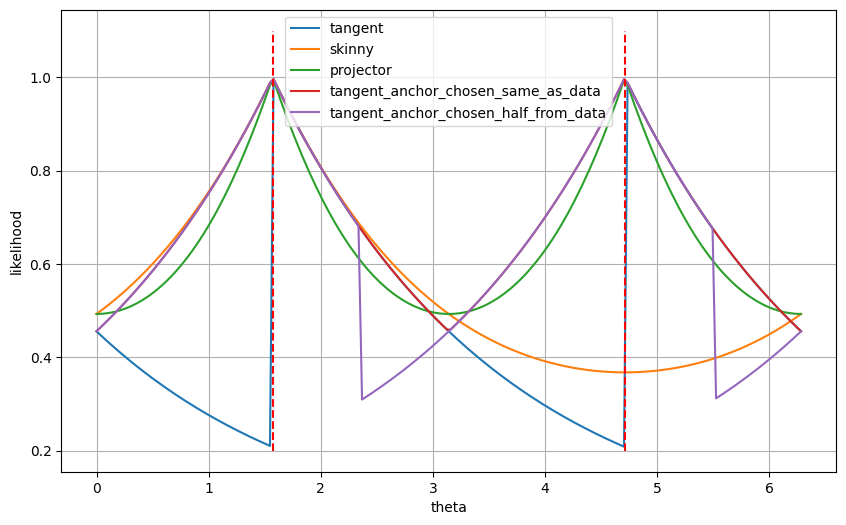

In [21]:
for name, likes in likelihoods.items():
    plt.plot(thetas, likes, label=name)
plt.vlines([theta,theta+np.pi],0.2,1.1,colors=['red','green'],linestyles='dashed')
plt.xlabel('theta')
plt.ylabel('likelihood')
plt.legend()
plt.grid()
plt.show()

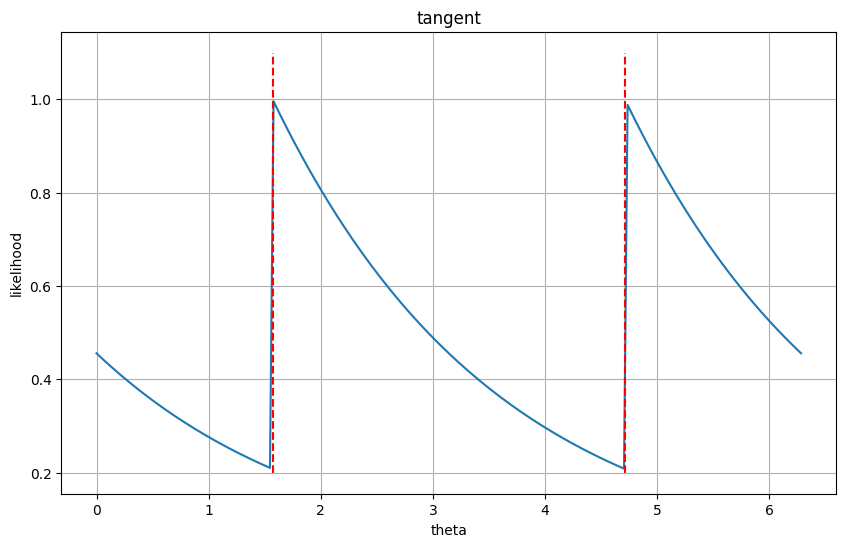

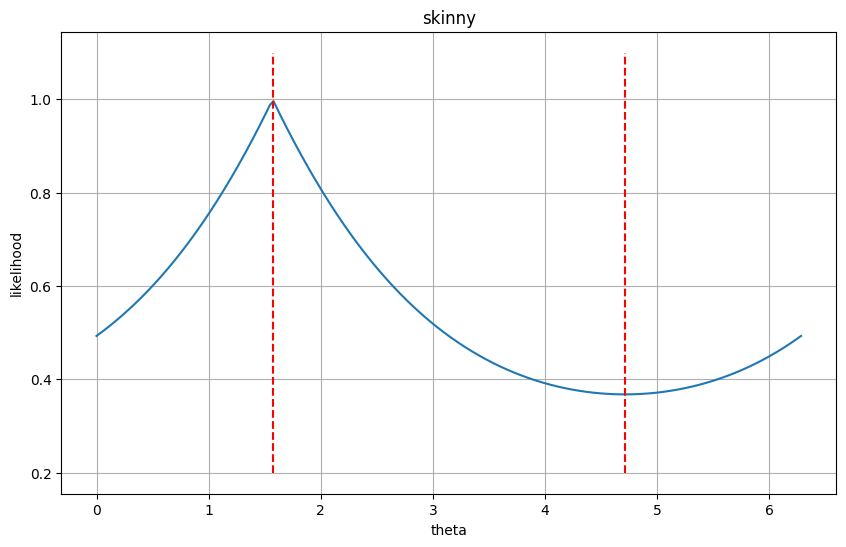

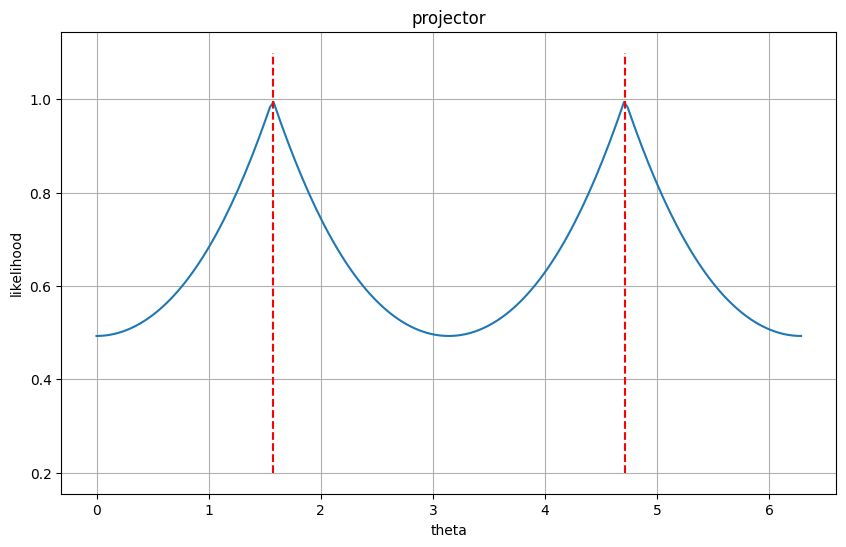

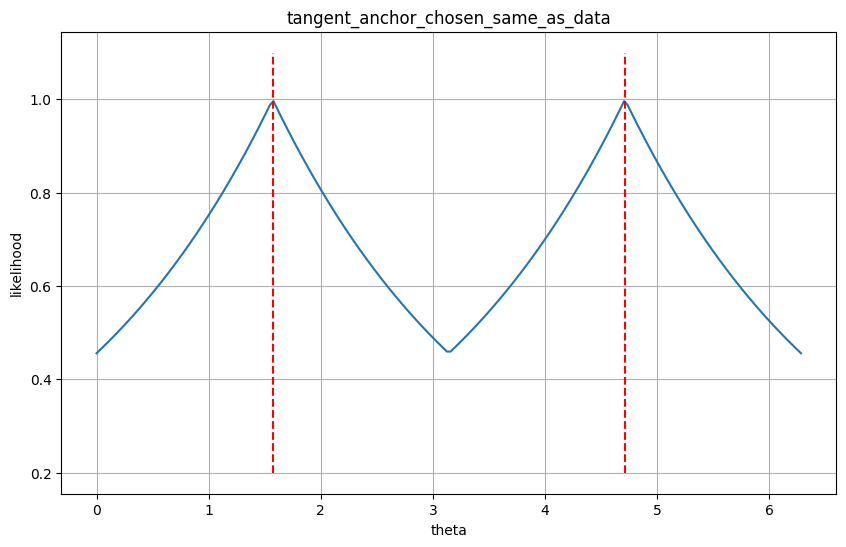

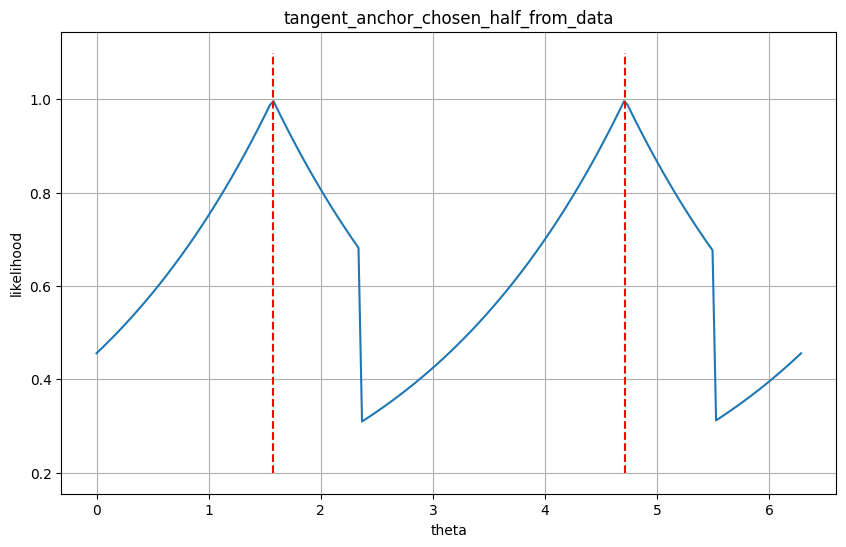

In [22]:
for name, likes in likelihoods.items():
    plt.plot(thetas, likes)
    plt.vlines([theta,theta+np.pi],0.2,1.1,colors=['red','green'],linestyles='dashed')
    plt.xlabel('theta')
    plt.ylabel('likelihood')
    plt.title(name)
    plt.grid()
    plt.show()